In [1]:
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')
  
from seismicpro.src import FieldIndex, SeismicBatch, SeismicDataset
from seismicpro.src.seismic_metrics import MetricsMap, SemblanceMetrics
from seismicpro.batchflow import I, V, B, Pipeline, R, P

In [2]:
path_raw = '../datasets/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '../datasets/DN02B_SHOTS_LIFT1.sgy'
index = (FieldIndex(name='raw', extra_headers=['offset', 'SourceX', 'SourceY'], path=path_raw)
         .merge(FieldIndex(name='lift', extra_headers=['offset', 'SourceX', 'SourceY'], path=path_lift)))
dataset = SeismicDataset(index)

In [4]:
pipeline = (dataset.p
            .add_namespace(SemblanceMetrics)
            .init_variable('metrics')
            .init_variable('metrics1')
            .load(fmt='segy', components=('raw', 'lift'), tslice=slice(3000))
            .sort_traces(src=('raw', 'lift'), dst=('raw', 'lift'), sort_by='offset')
            .apply_transform(func=lambda x, y: x - y, src=('raw', 'lift'), dst='raw')
            .calculate_semblance(src='raw', dst='raw_semblance', velocities=[1300, 5500], step=30)
            .calculate_minmax(B(), src='raw_semblance', dst='minmax_metrics')
            .gather_metrics(MetricsMap, index=B('index'), coords=["SourceX", "SourceY"],
                            metrics=B('minmax_metrics'), save_to=V('metrics', mode='a'))
            .run_later(1, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

In [5]:
pipeline.run()

100%|██████████| 51/51 [10:57<00:00, 12.89s/it]


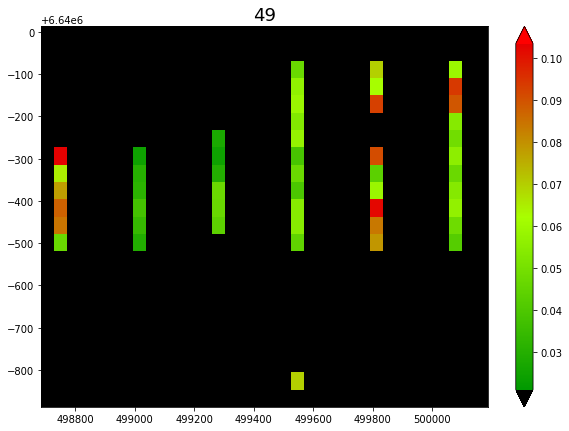

Mean value of metrics: 0.0559


In [8]:
metrics = pipeline.v('metrics')
mean_metrics = metrics.evaluate('map', bin_size=49, title='49', figsize=(10, 7), save_dir=None, pad=True)
print('Mean value of metrics: {:.3}'.format(mean_metrics))